In [1]:
import sys
sys.path.insert(0, '/home/jovyan/work/workspace/software/py_esdc/')
sys.path.insert(0, '/home/jovyan/work/workspace/projects/sakame')

# from showprogress import showprogress
import xarray as xr
import numpy as np
import pandas as pd
import h5py

from processing import PrelimAnalysis

from py_esdc.data import ESDCData
from py_esdc.data import window_xy, get_xy_indices
from py_esdc.utils import xarray2df

from ipywidgets import interact 
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.simplefilter('ignore')
from dask.diagnostics import ProgressBar
import matplotlib.cm as cm

%load_ext autoreload
%autoreload 2

In [2]:
data_analysis = PrelimAnalysis()

In [3]:
xr_dataset = data_analysis.get_variables()

In [4]:
xr_dataset

<xarray.Dataset>
Dimensions:                     (lat: 720, lon: 1440, time: 138)
Coordinates:
  * lat                         (lat) float32 89.875 89.625 ... -89.625 -89.875
  * lon                         (lon) float32 -179.875 -179.625 ... 179.875
  * time                        (time) datetime64[ns] 2009-01-05 ... 2011-12-31
Data variables:
    gross_primary_productivity  (time, lat, lon) float32 dask.array<shape=(138, 720, 1440), chunksize=(138, 90, 90)>
    root_moisture               (time, lat, lon) float32 dask.array<shape=(138, 720, 1440), chunksize=(138, 90, 90)>

In [5]:
t = ['2009', '2011', '2010']
t.sort()

In [6]:
t

['2009', '2010', '2011']

In [7]:
figure_path = '/home/jovyan/work/workspace/projects/sakame/figures/dependence/'

In [8]:
ESDC_data = xr.open_zarr("/home/jovyan/work/datacube/ESDCv2.0.0/esdc-8d-0.25deg-184x90x90-2.0.0.zarr")

### Extract Variables

In [9]:
rm = ESDC_data.root_moisture.sel(time=slice(str(2009), str(2011)))
gpp = ESDC_data.gross_primary_productivity.sel(time=slice(str(2009), str(2011)))

In [10]:
data = xr.merge([rm, gpp])

In [11]:
data

<xarray.Dataset>
Dimensions:                     (lat: 720, lon: 1440, time: 138)
Coordinates:
  * lat                         (lat) float32 89.875 89.625 ... -89.625 -89.875
  * lon                         (lon) float32 -179.875 -179.625 ... 179.875
  * time                        (time) datetime64[ns] 2009-01-05 ... 2011-12-31
Data variables:
    root_moisture               (time, lat, lon) float32 dask.array<shape=(138, 720, 1440), chunksize=(138, 90, 90)>
    gross_primary_productivity  (time, lat, lon) float32 dask.array<shape=(138, 720, 1440), chunksize=(138, 90, 90)>

### Extract Areas of Interest

In [12]:
# Europe
rm_europe = rm.sel(lat = slice(70.,30.), lon = slice(-20.,35.))
gpp_europe = gpp.sel(lat = slice(70.,30.), lon = slice(-20.,35.))

# Russia

# Europe
rm_russian = rm.sel(lat = slice(60.,50.), lon = slice(30.,60.))
gpp_russian = gpp.sel(lat = slice(60.,50.), lon = slice(30.,60.))


### Visualize: Yearly Mean

<Figure size 432x288 with 0 Axes>

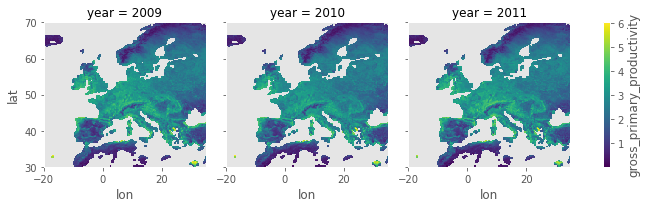

<Figure size 432x288 with 0 Axes>

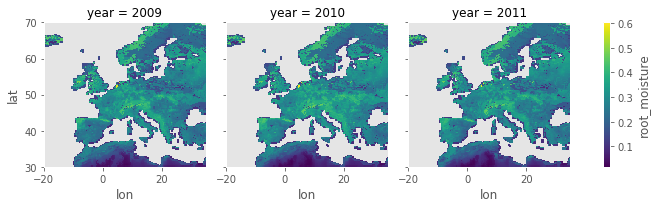

In [13]:
plt.figure()
gpp_europe.groupby('time.year').mean(dim='time').plot.pcolormesh(x='lon',y='lat',col='year',col_wrap=3)
plt.savefig(figure_path + 'gpp_europe.png')
plt.show()


plt.figure()
rm_europe.groupby('time.year').mean(dim='time').plot.pcolormesh(x='lon',y='lat',col='year',col_wrap=3)
plt.savefig(figure_path + 'rm_europe.png')
plt.show()

<Figure size 432x288 with 0 Axes>

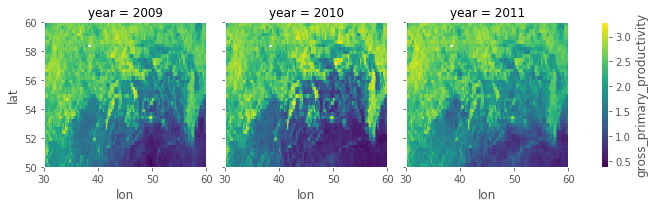

<Figure size 432x288 with 0 Axes>

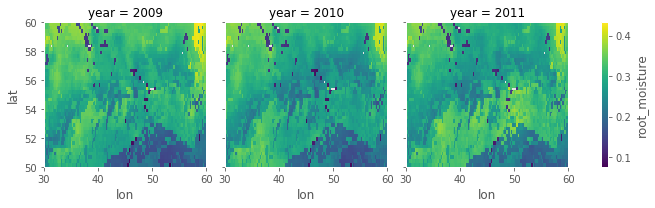

In [14]:
plt.figure()
gpp_russian.groupby('time.year').mean(dim='time').plot.pcolormesh(x='lon',y='lat',col='year',col_wrap=3)
plt.savefig(figure_path + 'gpp_russia.png')
plt.show()

plt.figure()
rm_russian.groupby('time.year').mean(dim='time').plot.pcolormesh(x='lon',y='lat',col='year',col_wrap=3)
plt.savefig(figure_path + 'rm_russia.png')
plt.show()

### Monthly Stats

In [15]:
# Function for Standardizing the Data
def standardize(x):
    return (x - x.mean()) / x.std()

In [16]:
# Calculate the Mean for every time step
gpp_mean = gpp_europe.groupby('time.year').mean(dim=['lat', 'lon'])
rm_mean = rm_europe.groupby('time.year').mean(dim=['lat', 'lon'])
gpp_mean_r = gpp_russian.groupby('time.year').mean(dim=['lat', 'lon'])
rm_mean_r = rm_russian.groupby('time.year').mean(dim=['lat', 'lon'])

# fig, ax = plt.subplots(figsize=(12,5), nrows=1, ncols=2)
# gpp_mean.plot(ax=ax[0], label='Europe')
# gpp_mean_r.plot(ax=ax[0], label='Russia')

# rm_mean.plot(ax=ax[1], label='Europe')
# rm_mean_r.plot(ax=ax[1], label='Russia')
# plt.show()
# fig.savefig(figure_path + 'monthly.png')

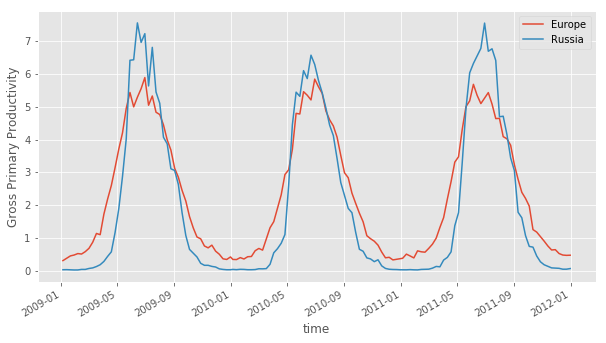

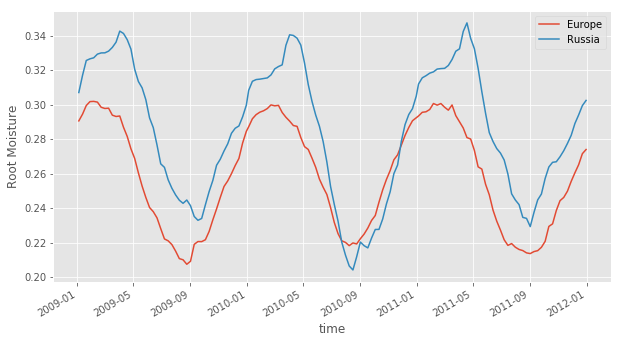

In [17]:
fig, ax = plt.subplots(figsize=(10, 5), nrows=1, ncols=1)

gpp_mean.plot(ax=ax, label='Europe')
gpp_mean_r.plot(ax=ax, label='Russia')
ax.legend()
ax.set_ylabel('Gross Primary Productivity')
# ax.set_title('Europe')
plt.show()
fig.savefig(figure_path + 'montly_gpp.png')

fig, ax = plt.subplots(figsize=(10, 5), nrows=1, ncols=1)

rm_mean.plot(ax=ax, label='Europe')
rm_mean_r.plot(ax=ax, label='Russia')
ax.legend()
ax.set_ylabel('Root Moisture')
plt.show()
fig.savefig(figure_path + 'montly_rm.png')

In [18]:
gpp_mean_std = (gpp_mean - gpp_mean.mean()) / gpp_mean.std()
rm_mean_std = (rm_mean - rm_mean.mean()) / rm_mean.std()

gpp_mean_std_r = (gpp_mean_r - gpp_mean_r.mean()) / gpp_mean_r.std()
rm_mean_std_r = (rm_mean_r - rm_mean_r.mean()) / rm_mean_r.std()

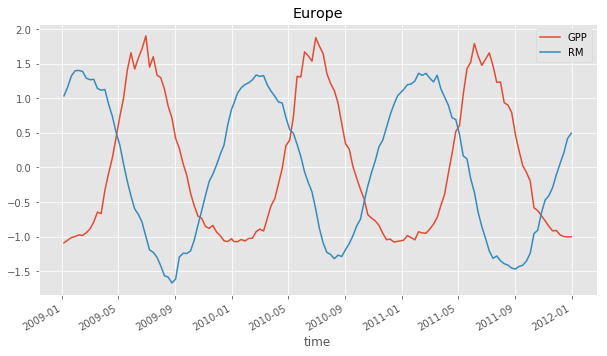

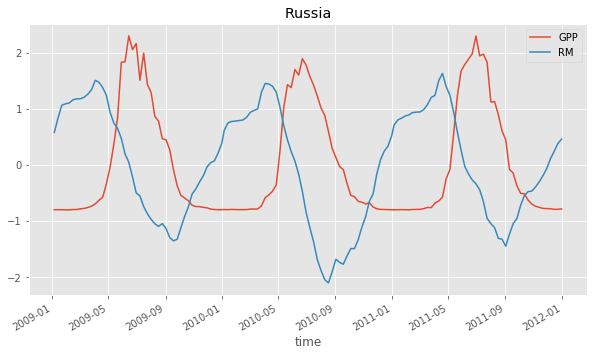

In [19]:
fig, ax = plt.subplots(figsize=(10, 5), nrows=1, ncols=1)

gpp_mean_std.plot(ax=ax, label='GPP')
rm_mean_std.plot(ax=ax, label='RM')
ax.legend()
ax.set_ylabel('')
ax.set_title('Europe')
plt.show()
fig.savefig(figure_path + 'montly_europe_std.png')

fig, ax = plt.subplots(figsize=(10, 5), nrows=1, ncols=1)

gpp_mean_std_r.plot(ax=ax, label='GPP')
rm_mean_std_r.plot(ax=ax, label='RM')
ax.legend()
ax.set_ylabel('')
ax.set_title('Russia')
plt.show()
fig.savefig(figure_path + 'montly_russia_std.png')

### Correlation

In [20]:
def get_corr(xr_data1, xr_data2):
    X = (xr_data1 - xr_data1.mean(dim='time', skipna=None))
    Y = (xr_data2 - xr_data2.mean(dim='time', skipna=None))
    
    # Get the covariance matrix
    cov = (X * Y)

    X_std = xr_data1.std(dim='time')
    Y_std = xr_data2.std(dim='time')

    corr_coef = (cov / (X_std * Y_std)).mean(dim=['lat', 'lon'])
    
    return corr_coef

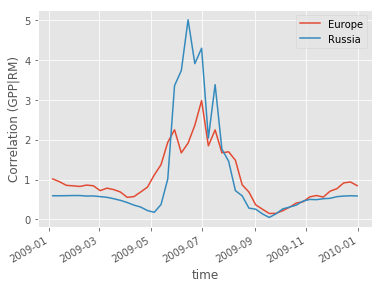

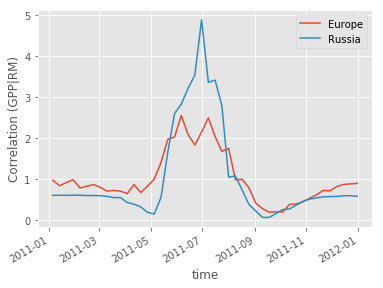

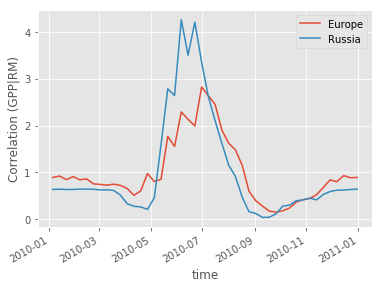

In [21]:
years = ['2009', '2011', '2010']

for iyear in years:
    # Extract for
    gpp_sub = gpp_europe.sel(time=slice(iyear, iyear))
    rm_sub = gpp_europe.sel(time=slice(iyear, iyear))
    gpp_sub_r = gpp_russian.sel(time=slice(iyear, iyear))
    rm_sub_r = gpp_russian.sel(time=slice(iyear, iyear))
    corr_europe = get_corr(gpp_sub, rm_sub)
    corr_russia = get_corr(gpp_sub_r, rm_sub_r)
    fig, ax = plt.subplots()

    corr_europe.plot(ax=ax, label='Europe')
    corr_russia.plot(ax=ax, label='Russia')
    ax.legend()
    ax.set_ylabel('Correlation (GPP|RM)')
    plt.show()
    fig.savefig(figure_path + f"corr_{iyear}.png")